# Hazard assessment for coastal flooding


Click [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/CLIMAAX/FLOODS/main?labpath=Hazard_assessment_FLOOD_COASTAL.ipynb) to open this workflow on Binder.  
Click [![Coastal flood](https://img.shields.io/badge/FLOOD-repository-blue)](https://github.com/CLIMAAX/FLOODS) to go to this workflow's GitHub repository.

## Hazard assessment methodology

In this workflow we will map the river flood hazard. In this workflow we use the dataset of [Joint Research Centre](https://data.jrc.ec.europa.eu/dataset/1d128b6c-a4ee-4858-9e34-6210707f3c81) openly available via the Joint Research Center Data Catalogue.

In this dataset European flood maps are available for only one scenario:
 - Present day climate (ca. 2018).

Within the scenario several flood maps are available, corresponding to extremes with different statistical occurence (10, 20, 50, 100, 200, 500 year return periods). The dataset has a 100 m. In this workflow we retrieve the relevant parts of the river flood hazard dataset and explore it in more detail for the region of interest.

Before proceeding with the hazard mapping, please take a moment to learn more about the background of the coastal flood map dataset and learn what you should consider when using this dataset to assess flood risk in a local context:

`````{admonition} Dataset of coastal flood map potential and its applicability for local hazard assessment
:class: hint dropdown
The methodology behind this dataset is documented and can be accessed through this ([article](https://doi.org/10.5194/essd-14-1549-2022)).

Several things to take into account when interpreting the flood maps:
 - This dataset helps to understand the **river flood potential** at a given location. The flood modelling in this dataset does not account for man-made protections that may already be in place in populated regions (e.g. dams, levees, dykes). Therefore, it is always important to survey the local circumstances when interpreting the flood maps.

For a more accurate estimate of river flood risks, it is recommended to perform local flood modelling, taking the results of the global model as boundary conditions. Local models can take better account of complex topography, and incorporate local data and knowledge about e.g. flood protection measures.
`````

## Preparation work

### Select area of interest
Before downloading the data, we will define the coordinates of the area of interest. Based on these coordinates we will be able to clip the datasets for further processing, and eventually display hazard and damage maps for the selected area.

To easily define an area in terms of geographical coordinates, you can go to the [Bounding Box Tool](https://boundingbox.klokantech.com/) to select a region and get the coordinates. Make sure to select 'CSV' in the lower left corner and copy the values in the brackets below. Next to coordinates, please specify a name for the area which will be used in plots and saved results.

In [122]:
## name the area for saving datasets and plots# specify the coordinates of the bounding box
bbox = [1.983871,41.252461,2.270614,41.449569] # Barcelona, Spain
areaname = 'Barcelona_Spain'

# Examples:
# bbox = [-1.6,46,-1.05,46.4]; areaname = 'La_Rochelle' 
#bbox = [1.983871,41.252461,2.270614,41.449569]; areaname = 'Barcelona'
#bbox = [12.1,45.1,12.6,45.7]; areaname = 'Venice'
#bbox = [-9.250441,38.354403,-8.618666,38.604761]; areaname = 'Setubal'

### Load libraries

`````{admonition} Find more info about the libraries used in this workflow here
:class: hint dropdown

In this notebook we will use the following Python libraries:
- [os](https://docs.python.org/3/library/os.html) - Provides a way to interact with the operating system, allowing the creation of directories and file manipulation.
- [pooch](https://www.fatiando.org/pooch/latest/index.html) - A data retrieval and storage utility that simplifies downloading and managing datasets.
- [numpy](https://numpy.org/) - A powerful library for numerical computations in Python, widely used for array operations and mathematical functions.
- [pandas](https://pandas.pydata.org/) - A data manipulation and analysis library, essential for working with structured data in tabular form.
- [rasterio](https://rasterio.readthedocs.io/en/stable/) - A library for reading and writing geospatial raster data, providing functionalities to explore and manipulate raster datasets.
- [rioxarray](https://corteva.github.io/rioxarray/stable/) - An extension of the xarray library that simplifies working with geospatial raster data in GeoTIFF format.
- [damagescanner](https://damagescanner.readthedocs.io/en/latest/#) - A library designed for calculating flood damages based on geospatial data, particularly suited for analyzing flood impact.
- [matplotlib](https://matplotlib.org/) - A versatile plotting library in Python, commonly used for creating static, animated, and interactive visualizations.
- [contextily](https://contextily.readthedocs.io/en/latest/) A library for adding basemaps to plots, enhancing geospatial visualizations.


These libraries collectively enable the download, processing, analysis, and visualization of geospatial and numerical data, making them crucial for this risk workflow.
`````

In [123]:
# Package for downloading data and managing files
import os
import pooch

# Packages for working with numerical data and tables
import numpy as np
import pandas as pd

# Packages for handling geospatial maps and data
import rioxarray as rxr
import rasterio
from rasterio.enums import Resampling

# Package for calculating flood damages
from damagescanner.core import RasterScanner

# Ppackages used for plotting maps
import matplotlib.pyplot as plt
import contextily as ctx


### Create the directory structure
In order for this workflow to work even if you download and use just this notebook, we need to set up the directory structure.  
Next cell will create the directory called 'FLOOD_River_hazard' in the same directory where this notebook is saved.

In [124]:
# Define the folder for the flood workflow
workflow_folder = 'FLOOD_River_hazard'

# Check if the workflow folder exists, if not, create it
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)

general_data_folder = os.path.join(workflow_folder, 'general_data')

# Check if the general data folder exists, if not, create it
if not os.path.exists(general_data_folder):
    os.makedirs(general_data_folder)

In [125]:
# Define directories for data and plots within the previously defined workflow folder
data_dir = os.path.join(workflow_folder, f'data_{areaname}')
plot_dir = os.path.join(workflow_folder, f'plots_{areaname}')

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

## Download and view the river flood map dataset

First we download the flood data for 10, 20, 50, 100, 200 and 500 years.  

In the list of **return_periods**, first value is the return period, and second value is the hash.  

Next cell will:
- create the create the **data** folder inside the notebook folder
- Loop through all return periods and download and unzip each file in the data folder (if the data doesn't already exist).

Data for each return period can also be manually downloaded from [this link](https://data.jrc.ec.europa.eu/dataset/1d128b6c-a4ee-4858-9e34-6210707f3c81) in the JRC data portal.

In [126]:
# Define a list of return periods with associated hash values
return_periods = [('010', '6dfba3cba22bf99fefb45e66963b8dbf7054e81b8a6b46258eff6ffda686d2a4'), 
                  ('020', 'a497725f7edf00ed01f3084e3d755b77294c53939b5f7ad5174f59c0331a5d34'), 
                  ('050', '47a804f617b0bbc9646ae3274e4959ba21edf4ef2bac778051f86ce7fcf4cde5'), 
                  ('100', 'cecda59c96d6dcd340a1ff2e82efc1caabd5c98d650b70fca5e802fd01872cae'),
                  ('200', '9988c310a306c8244fda542b6e5ea2956a5b98ffc06ed3104cef869443646533'),
                  ('500', 'a64803d8e31ca35bff0e386388d44b06674c78e3e8777e1d44a05098e0730268')]

# Loop through each return period and download the corresponding flood map
for item in return_periods:
    return_period, khash = item
    url = f'https://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/FLOODS/EuropeanMaps/floodMap_RP{return_period}.zip'
    pooch.retrieve(
        url=url,
        known_hash=khash,
        processor=pooch.Unzip(extract_dir=''),
        path=general_data_folder,
    )

To check the dataset we select the 500 year return period map

In [127]:
# select first item from the search and open the dataset 
ds = rxr.open_rasterio(f"{general_data_folder}/floodmap_EFAS_RP500_C.tif")

We have opened the first dataset. The extent of the dataset is European, therefore the number of points along latitude and longitude axes is very large. This dataset needs to be clipped to our area of interest and reprojected to local coordinates (to view the maps with distances indicated in meters instead of degrees latitude/longitude). 

We can view the contents of the raw dataset.

In [128]:
ds

<xarray.DataArray (band: 1, y: 45242, x: 63976)>
[2894402192 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 9.19e+05 9.19e+05 9.192e+05 ... 7.316e+06 7.316e+06
  * y            (y) float64 5.441e+06 5.44e+06 5.44e+06 ... 9.166e+05 9.164e+05
    spatial_ref  int32 0
Attributes: (12/13)
    AREA_OR_POINT:           Area
    DataType:                Generic
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  8.857045422371877
    STATISTICS_MAXIMUM:      276.49700927734
    STATISTICS_MEAN:         2.3875402056979
    ...                      ...
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       2.976078866961
    _FillValue:              -3.402823e+38
    scale_factor:            1.0
    add_offset:              0.0

Now we will clip the dataset to a wider area around the region of interest, and call it *ds_local*. The extra margin is added to account for reprojection at a later stage. The clipping of the dataset allows to reduce the total size of the dataset so that it can be loaded into memory for faster processing and plotting.

In [129]:
ds_local = ds.rio.clip_box(
    *bbox,
    crs="EPSG:4326", # provide the crs of the bounding box coordinates
)

# reproject ds_local to 3035
ds_local = ds_local.rio.reproject("EPSG:3035")

In [130]:
ds_local.rio.resolution()

(100.00000000000001, -100.00000000000001)

We can now plot the dataset to view the flood map a return period. You can adjust the bounds of the colorbar by changing the *vmax* variable to another value (in meters).

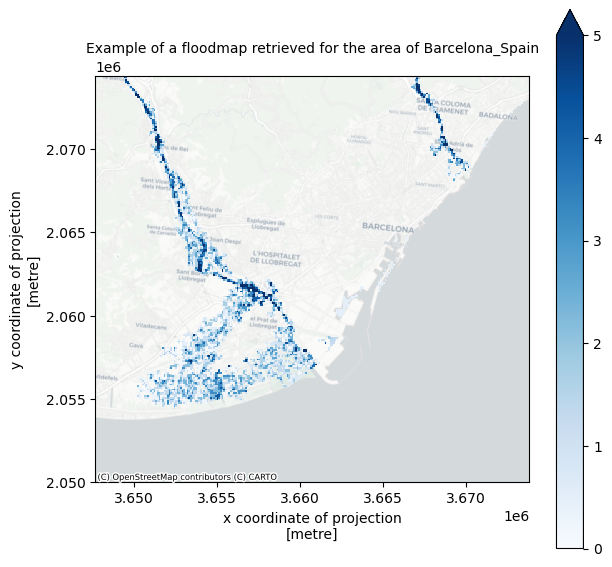

In [131]:
fig, ax = plt.subplots(figsize=(7, 7))
bs=ds_local.where(ds_local > 0).plot(ax=ax,cmap='Blues',alpha=1,vmin=0,vmax=5)
ctx.add_basemap(ax=ax,crs='EPSG:3035',source=ctx.providers.CartoDB.Positron, attribution_size=6)
plt.title(f'Example of a floodmap retrieved for the area of {areaname}',fontsize=10);

## Combining return periods into one dataset
In our hazard and risk assessments, we would like to be able to compare the flood maps for different scenarios and return periods. For this, we will load and merge the datasets for different scenarios and return periods in one dataset, where the flood maps can be easily accessed. Below a function is defined which contains the steps described above for an individual dataset. 

In [132]:
# combine the above steps into a function to load flood maps per year and return period

def load_floodmaps(path):

    ds = rxr.open_rasterio(path)
    ds_local = ds.rio.clip_box(
    *bbox,
    crs="EPSG:4326", # provide the crs of the bounding box coordinates
    )

    # reproject ds_local to 3035
    ds_local = ds_local.rio.reproject("EPSG:3035")
    ds_floodmap = ds_local.where(ds_local > 0)
    del ds_local
    return ds_floodmap

We can now apply this function, looping over the selection of return periods. 


In [133]:
# load all floodmaps in one dataset
rps = ['010','020','050','100','200', '500'] # list of return periods (all: 2,5,10,25,50,100,250 yrs)
import xarray as xr
for rp in rps: 
    path = f"{general_data_folder}/floodmap_EFAS_RP{rp}_C.tif"
    ds = load_floodmaps(path)
    # set name of the dataset
    ds.name = f'{rp}'

    if rp==rps[0]:
        floodmaps = ds
    else:
        # use xarray to merge the datasets
        # different return periods are stored as different coordinates
        floodmaps = xr.merge([floodmaps,ds],combine_attrs="drop_conflicts")
        
    del ds       

floodmaps

<xarray.Dataset>
Dimensions:      (x: 261, y: 244, band: 1)
Coordinates:
  * x            (x) float64 3.648e+06 3.648e+06 ... 3.674e+06 3.674e+06
  * y            (y) float64 2.074e+06 2.074e+06 2.074e+06 ... 2.05e+06 2.05e+06
  * band         (band) int32 1
    spatial_ref  int32 0
Data variables:
    010          (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    020          (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    050          (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    100          (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    200          (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    500          (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    AREA_OR_POINT:           Area
    DataType:                Generic
    RepresentationType:      ATHEMATIC
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              -3.402823e+38
    STATISTICS_MINIMUM:      0.10000000149012

The *floodmaps* variable now contains the flood maps for different return periods. We can continue with viewing the contents.

## Visualize coastal flood hazard dataset
Now we can compare the maps of flood potential in different different return periods. We will plot the maps next to each other:

In [134]:
# get the max of all datavariables in floodmaps
floodmaps.max()

<xarray.Dataset>
Dimensions:      ()
Coordinates:
    spatial_ref  int32 0
Data variables:
    010          float32 13.64
    020          float32 13.76
    050          float32 13.9
    100          float32 13.99
    200          float32 14.07
    500          float32 14.16

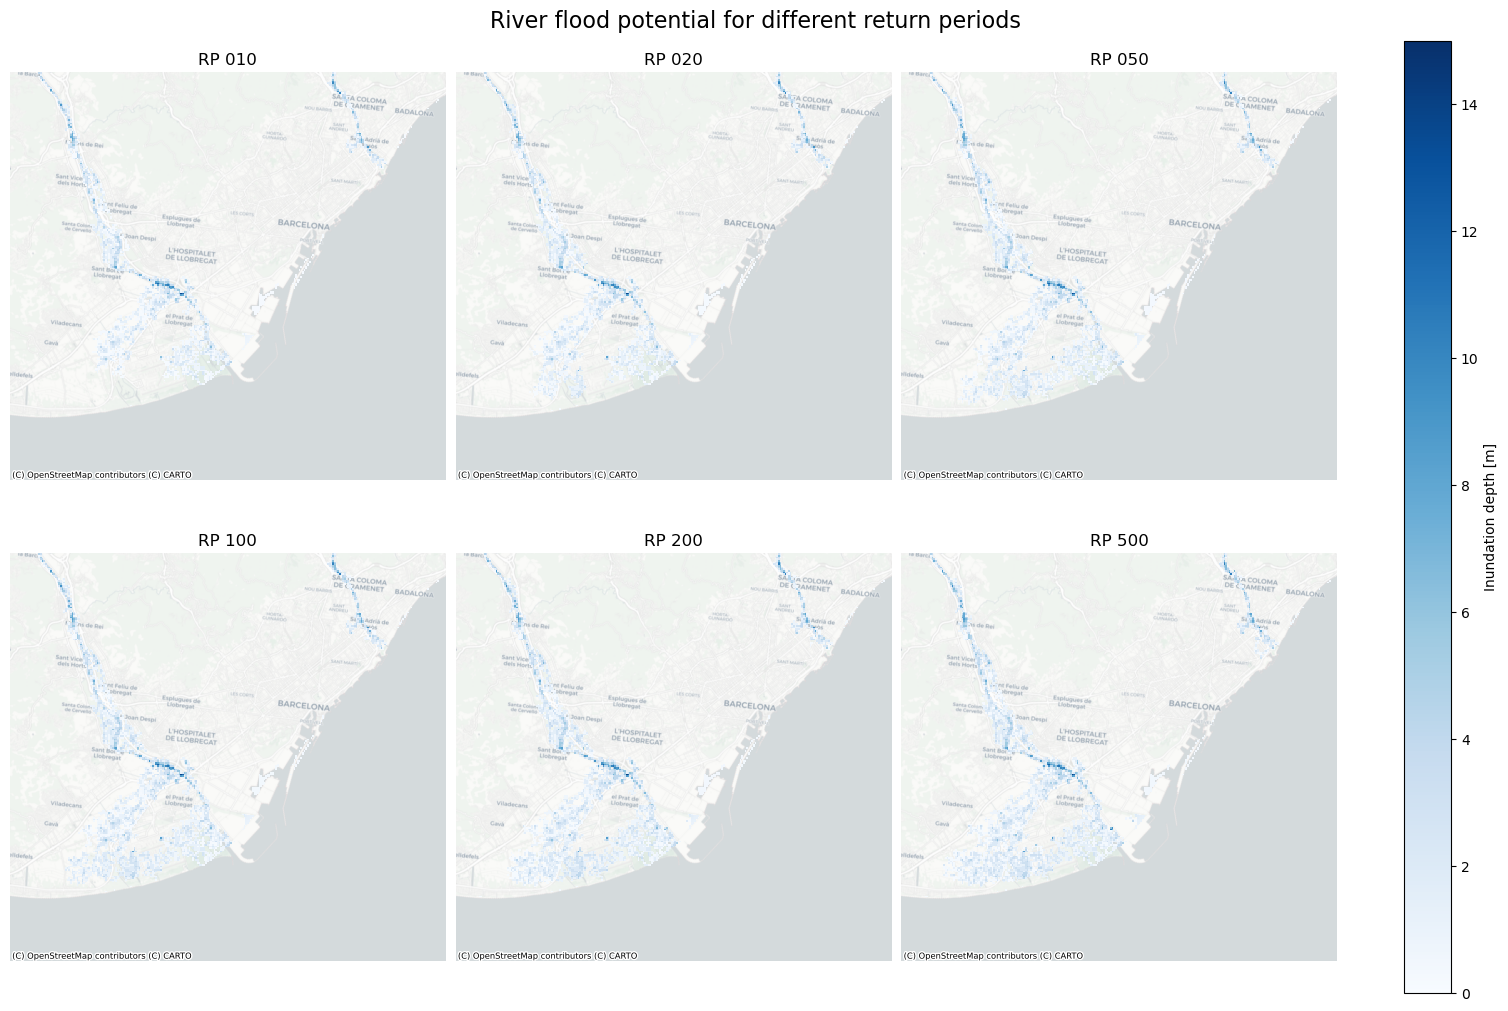

In [146]:
import matplotlib.pyplot as plt
import contextily as ctx
import os

fig, axs = plt.subplots(figsize=(15, 10), nrows=2, ncols=len(rps) // 2, constrained_layout=True, sharex=True, sharey=True)

max_inundation = 15 # see the highest number in the above output

# Assuming you have an even number of return periods
nrows = 2
ncols = len(rps) // nrows

for i, rp in enumerate(rps):
    row, col = divmod(i, ncols)
    bs = floodmaps[f'{rp}'].plot(ax=axs[row, col], cmap='Blues', vmin=0, vmax=max_inundation, add_colorbar=False)
    axs[row, col].set_title(f'RP {rp}')
    ctx.add_basemap(ax=axs[row, col], crs='EPSG:3035', source=ctx.providers.CartoDB.Positron, attribution_size=6)
    axs[row, col].set_axis_off()

# Adjust how you set the colorbar to span all plots
fig.colorbar(bs, ax=axs.ravel().tolist(), orientation="vertical", label='Inundation depth [m]')  
fig.suptitle('River flood potential for different return periods', fontsize=16)

fileout = os.path.join(plot_dir, f'Floodmap_{areaname}_overview.png')
fig.savefig(fileout)


## Save dataset to a local directory for future access
Now that we have loaded the full dataset, we will save it to a local folder to be able to easily access it later. There are two options for saving the dataset: as a single netCDF file containing all scenarios, and as separate raster files (**.tif** format).

In [138]:
# save the full dataset to netCDF file
fileout = os.path.join(data_dir,f'floodmaps_all_{areaname}.nc')
floodmaps.to_netcdf(fileout) 
del fileout

In [145]:
# save individual flood maps to raster files

for rp in rps: 
    floodmap_file = os.path.join(data_dir, f'floodmap_{areaname}_{rp}.tif') 
    da = floodmaps[rp][0] # select data array

    with rasterio.open(floodmap_file,'w',driver='GTiff',
        height=da.shape[0],
        width=da.shape[1],
        count=1,dtype=str(da.dtype),
        crs=da.rio.crs, transform=da.rio.transform()) as dst:
        dst.write(da.values,indexes=1) # Write the data array values to the rasterio dataset

## Conclusions

In this hazard workflow we learned:
 - How to retrieve river flood maps for your specific region.
 - Understanding the differences between return periods.

The river flood hazard maps that were retrieved and saved locally in this workflow will be further used in the river flood risk workflow (part of the risk toolbox).



## Contributors

Applied research institute Deltares (The Netherlands)

Institute for Environmental Studies, VU Amsterdam (The Netherlands)

Authors of the workflow: 
Ted Buskop
